## Equation Discovery (first attempt + guide notebook)

Author: Antony Sikorski 

My attempt at rediscovering the parameterization equation for pressure redistribution using high resolution, Large Eddy Simulation (LES) data. 

First, importing necessary libraries: 
- xarray, netcdf, and h5 are all for the data
- PySR is for symbolic regression (equation discovery). Github: https://github.com/MilesCranmer/PySR

In [1]:
import pysr
from pysr import PySRRegressor

import xarray as xr
import netCDF4 as nc
import h5netcdf

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


---
### Part 1: Data Exploration


Data is in netcdf file format. Files are named according to certain initial conditions that are set: 

- Ug: Imposed wind (large scale wind, geostrophic)
- Q: Surface heating (how much heat you're putting into your domain, initially affects the surface level)
- SI/WI: Strong/Weak Inversion (talking about the temperature inversion that occurs at the top of the ABL, will be visible when looking at the gradient of $\Theta$)

In this notebook, we will open two similar files: 

In [2]:
file_names = [
   'Ug1Q024_SI.nc', 'Ug2Q010_SI.nc', 'Ug2Q010_WI.nc', 'Ug2Q024_SI.nc', 'Ug2Q024_WI.nc',
   'Ug4Q024_SI.nc', 'Ug8Q003_WI.nc', 'Ug8Q006_WI.nc', 'Ug9Q024_SI.nc', 'Ug15Q010_SI.nc', 'Ug15Q024_SI.nc',
   'Ug16Q000_SI.nc', 'Ug16Q000_WI.nc', 'Ug16Q001_WI.nc', 'Ug16Q003_WI.nc', 'Ug16Q006_SI.nc', 'Ug16Q006_WI.nc',
   'Ug16Q010_WI.nc'
]

# all of my LES files are currently stored here
folder_path = 'C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim'

for file_name in file_names:
    print(file_name)
    df = nc.Dataset(folder_path + '/' + file_name, mode='r')
    print(df)
    df.close()

Ug1Q024_SI.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(24)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo
Ug2Q010_SI.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug2Q010_WI.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug2Q024_SI.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(z

In [3]:
file_path_1 = 'Ug2Q010_SI.nc'
file_path_2 = 'Ug2Q024_SI.nc' 
file_path_3 = 'Ug16Q006_SI.nc'
file_path_4 = 'Ug16Q010_WI.nc'

df_1 = nc.Dataset(folder_path + '/' + file_path_1, mode='r')
df_2 = nc.Dataset(folder_path + '/' + file_path_2, mode='r')
df_3 = nc.Dataset(folder_path + '/' + file_path_3, mode='r')
df_4 = nc.Dataset(folder_path + '/' + file_path_4, mode='r')

print(df_1)
print(df_2)
print(df_3)
print(df_4)
# #closing netCDF files since we extracted the data 
# df_1.close()
# df_2.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(90)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget


There are three groups which contain different variables: `default`, `thermo`, and `budget`. Typically the temperature terms are found in `thermo` etc. Variables in these groups will have values across two dimensions. 

One of the dimensions is always `time`. Depending on the variables, the other dimensions (height), will either be `z` or `zh`, because some variables are calculated at the center of a cell, other variables are calculate on the surfaces
This is due to the nature of "MicroHH", which is the CFD model we used for simulation. MicroHH is discretized on a staggered Arakawa C-grid, where the scalars are located in the center of a grid cell and the three velocity components are at the faces. Source code for this CFD model: https://github.com/microhh/microhh/tree/main/src

For this dataset, `time` has length 120 (minutes) because there are 2 hours of data. The LES is actually run for 4 hours, but the first two are chopped off. 

The resolution of our LES is $24 \times 24 \times 6$ $ m^3$. I think the variables we get are a result of averaging in the horizontal plane, thus we only retain a height (`z` or `zh`) variable. Let's take a look at all of the variables: 

In [4]:
for group_name, group in df_1.groups.items():
    print(f"Group: {group_name}")
    for var_name, var in group.variables.items():
        long_name = var.getncattr('long_name') if 'long_name' in var.ncattrs() else 'No long_name attribute'
        dimensions = var.dimensions if hasattr(var, 'dimensions') else 'No dimensions attribute'
        print(f"  Variable: {var_name},  Long Name: {long_name},  Dimensions: {dimensions}")

Group: default
  Variable: iter,  Long Name: Iteration number,  Dimensions: ('time',)
  Variable: area,  Long Name: Fractional area contained in mask,  Dimensions: ('time', 'z')
  Variable: areah,  Long Name: Fractional area contained in mask,  Dimensions: ('time', 'zh')
  Variable: eft,  Long Name: eft,  Dimensions: ('time', 'z')
  Variable: eft_3,  Long Name: Moment 3 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_4,  Long Name: Moment 4 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_diff,  Long Name: Diffusive flux of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_w,  Long Name: Turbulent flux of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_grad,  Long Name: Gradient of the eft,  Dimensions: ('time', 'zh')
  Variable: eft_2,  Long Name: Moment 2 of the eft,  Dimensions: ('time', 'z')
  Variable: eft_path,  Long Name: eft path,  Dimensions: ('time',)
  Variable: eft_flux,  Long Name: Total flux of the eft,  Dimensions: ('time', 'zh')
  Variable: sft,  Lo

In [5]:
testVariable = df_1.groups['budget'].variables['w2_pres']
testVariable[10, :] #all values of w_2 pres at each height (zh) for minute 10
# len(testVariable[10, :])

masked_array(data=[ 8.73857569e-03,  5.97471784e-03,  4.20977836e-03,
                    3.25524514e-03,  2.69512067e-03,  2.33818718e-03,
                    2.07543688e-03,  1.84334927e-03,  1.62033114e-03,
                    1.41262411e-03,  1.23145633e-03,  1.08727787e-03,
                    9.81766403e-04,  9.03153557e-04,  8.40756321e-04,
                    7.90972931e-04,  7.44003031e-04,  6.84391168e-04,
                    6.10361722e-04,  5.36809995e-04,  4.76896593e-04,
                    4.27092368e-04,  3.72742917e-04,  3.12106999e-04,
                    2.51734126e-04,  1.85604870e-04,  1.15246127e-04,
                    6.14095694e-05,  3.81688990e-05,  4.32064730e-05,
                    5.67458698e-05,  5.87802286e-05,  4.26656572e-05,
                    1.24459208e-05, -2.96051309e-05, -8.87626044e-05,
                   -1.58689082e-04, -2.11502094e-04, -2.27541212e-04,
                   -2.14727827e-04, -1.90554077e-04, -1.68749936e-04,
                   -

Let's take a look at some key variables, and try to recreate the figures in *"The non-local character of turbulence asymmetry in the convective atmospheric boundary layer" by Ghannam et al*. Link: https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.2937

We will initially focus on $\Theta$, $\frac{\mathrm{d}\Theta}{\mathrm{d}z}$, and $\overline{w' \theta'}$, which are mean potential temperature, its vertical gradient, and then turbulent heat flux, respectively. 

In [6]:
#extract variables from both df, name accordingly
Theta_WI = df_1.groups['thermo'].variables['th']
dTheta_dz_WI = df_1.groups['thermo'].variables['th_grad']
w_theta_WI = df_1.groups['thermo'].variables['th_flux']

Theta_SI = df_2.groups['thermo'].variables['th']
dTheta_dz_SI = df_2.groups['thermo'].variables['th_grad']
w_theta_SI = df_2.groups['thermo'].variables['th_flux']

# couldn't think of how to extract z, zh, t any better so I just did this. 
# someone please do this better 
z = xr.DataArray(Theta_WI, dims=Theta_WI.dimensions)['z'].values
zdim = len(z)
#assert(len(z) == 256)
zh = xr.DataArray(w_theta_WI, dims=w_theta_WI.dimensions)['zh'].values
zhdim = len(zh)
#assert(len(zh) == 257)
t = xr.DataArray(Theta_WI, dims=Theta_WI.dimensions)['time'].values
#assert(len(t) == 120)
tdim = len(t)

Quickly looking at the $\Theta$ in both the SI and WI. They are the same for SI and WI files of the same initial conditions, this is weird. 

In [7]:
print(Theta_WI[10, 140:160])
print(Theta_SI[10, 140:160])

[302.81463305 303.55277054 304.53284672 305.55134621 306.39478708
 306.99802291 307.40138174 307.66847328 307.84779288 307.96759419
 308.04579508 308.09566788 308.12711582 308.14777041 308.16341363
 308.17792221 308.19333678 308.21023327 308.22830016 308.24692501]
[303.1836669  303.24256067 303.31415678 303.40395896 303.5171679
 303.65916509 303.83847203 304.06819539 304.36217713 304.73091175
 305.1765007  305.68087983 306.2020587  306.69412998 307.1217008
 307.4690025  307.73615934 307.93051948 308.06598506 308.15669451]


First we look at the unnormalized weak inversion plots of these three key variables:

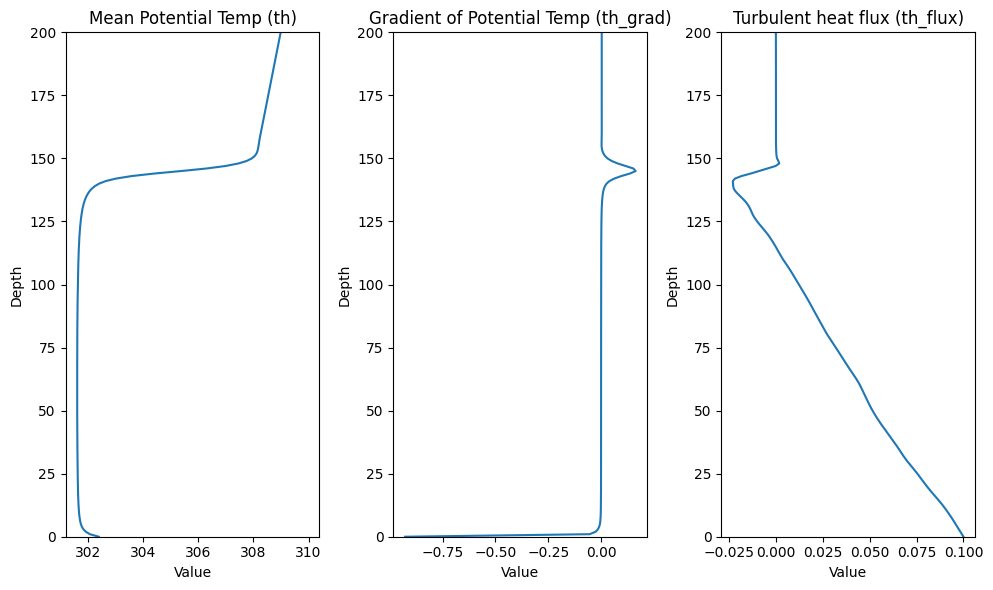

0.0013236301161932864 0.061570935887643


In [8]:
#pick a time at which to plot
timeStep = 60

#pick 'strong' or 'weak' inversion
inversion = '2' 

if inversion == '1':
    Theta = Theta_SI
    dTheta_dz = dTheta_dz_SI
    w_theta = w_theta_SI
if inversion == '2':
    Theta = Theta_WI
    dTheta_dz = dTheta_dz_WI
    w_theta = w_theta_WI

plt.figure(figsize = (10, 6))

# Plot potentialTemp
plt.subplot(1, 3, 1)
plt.plot(Theta[timeStep], np.arange(0, zdim))
plt.ylim(0, 200)
plt.title('Mean Potential Temp (th)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 3, 2)
plt.plot(dTheta_dz[timeStep], np.arange(0, zhdim))
plt.ylim(0, 200)
plt.title('Gradient of Potential Temp (th_grad)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 3, 3)
plt.plot(w_theta[timeStep], np.arange(0, zhdim))
plt.ylim(0, 200)
plt.title('Turbulent heat flux (th_flux)')
plt.xlabel('Value')
plt.ylabel('Depth')

# Show the plot
plt.tight_layout()
plt.show()

print(np.mean(dTheta_dz[timeStep]), np.std(dTheta_dz[timeStep]))

Normalizing the variables following the paper mentioned above in order to get more similar plots. We will use the weak inversion data. This normalization is definitely wrong at the moment. 

In [9]:
# # not quite sure how to get this, setting to one for now
# beta = 1

# #boundary layer height (changes with time??)
# h = df_1.groups['thermo'].variables['zi'][:]
# h = h[timeStep]
# h

# #surface heat flux (i think)?
# w_theta_0 = df_1.groups['thermo'].variables['th_flux'][timeStep][0]

# plt.figure(figsize = (10, 6))

# # Plot potentialTemp
# plt.subplot(1, 3, 1)
# plt.plot(Theta[timeStep], np.arange(0, 256))
# plt.ylim(0, 200)
# plt.title('Mean Potential Temp (th)')
# plt.xlabel('Value')
# plt.ylabel('Depth')

# # Plot th_diff
# plt.subplot(1, 3, 2)
# plt.plot((dTheta_dz[timeStep] * h * np.cbrt(beta * w_theta_0 * h))/w_theta_0,
#          np.arange(0, 257))
# plt.ylim(0,200)
# # plt.ylim(2, 200)
# # plt.xlim(-2000, 2000)
# plt.title('Gradient of Potential Temp (th_grad)')
# plt.xlabel('Value')
# plt.ylabel('Depth')

# # Plot th_flux
# plt.subplot(1, 3, 3)
# plt.plot(w_theta[timeStep]/w_theta_0,
#          np.arange(0, 257))
# plt.ylim(0, 200)
# plt.title('Turbulent heat flux (th_flux)')
# plt.xlabel('Value')
# plt.ylabel('Depth')

# # Show the plot
# plt.tight_layout()
# plt.show()

The gradient looks a little funky. Let's manually calculate the gradient and compare: 

Text(0, 0.5, 'Depth')

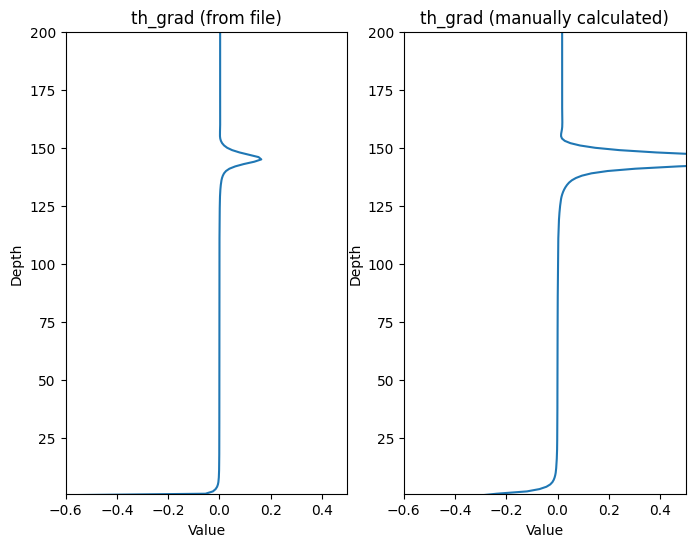

In [10]:
manualGrad = np.gradient(Theta[timeStep], z)

# #finite difference by hand
# manualGrad = np.zeros_like(poTemp)
# poTemp = Theta[timeStep]
# for i in range(1, len(poTemp)-1):
#     manualGrad[i] = (poTemp[i+1] - poTemp[i-1]) / (z[i+1] - z[i-1])

# # Handle the boundaries with forward and backward differences
# manualGrad[0] = (poTemp[1] - poTemp[0]) / (z[1] - z[0])
# manualGrad[-1] = (poTemp[-1] - poTemp[-2]) / (z[-1] - z[-2])

plt.figure(figsize = (8, 6))
plt.subplot(1, 2, 1)
plt.xlim(-0.6, 0.5)
plt.ylim(1, 200)
plt.plot(dTheta_dz[timeStep], np.arange(0, 257))
plt.title('th_grad (from file)')
plt.xlabel('Value')
plt.ylabel('Depth')

plt.subplot(1, 2, 2)
plt.plot(manualGrad, z)
plt.xlim(-0.6, 0.5)
plt.ylim(1, 200)
plt.title('th_grad (manually calculated)')
plt.xlabel('Value')
plt.ylabel('Depth')

The gradients appear pretty different. Could be due to finite differencing.

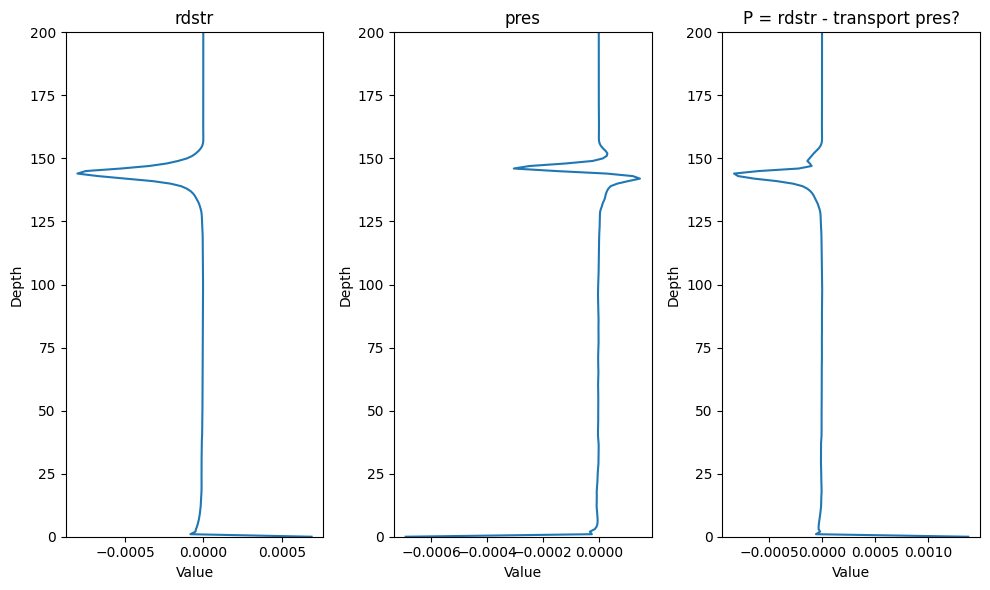

In [11]:
rdstr = df_1.groups['budget'].variables['bw_rdstr']
transport = df_1.groups['budget'].variables['bw_pres']

plt.figure(figsize = (10, 6))

# Plot potentialTemp
plt.subplot(1, 3, 1)
plt.plot(rdstr[timeStep], np.arange(0, zhdim))
plt.ylim(0, 200)
plt.title('rdstr')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_diff
plt.subplot(1, 3, 2)
plt.plot(transport[timeStep], np.arange(0, zhdim))
plt.ylim(0, 200)
plt.title('pres')
plt.xlabel('Value')
plt.ylabel('Depth')

# Plot th_flux
plt.subplot(1, 3, 3)
plt.plot(rdstr[timeStep] - transport[timeStep], np.arange(0, zhdim))
plt.ylim(0, 200)
plt.title('P = rdstr - transport pres?')
plt.xlabel('Value')
plt.ylabel('Depth')

# Show the plot
plt.tight_layout()
plt.show()

---
### Part 2: Symbolic Regression

Let's try some symbolic regression. In this experiment, we will take a slice of the atmosphere at some height value, and will feed in all of the time steps (120) data points. We will do this for both the SI and WI, and combine their vectors to give us a total of $240$ instances.

In [12]:
#just looking at the values of the variables

print(dTheta_dz[60, 125:155])
print(w_theta[60, 125:155])
print(Theta[60, 125:155])

[0.00157419 0.00176018 0.00194617 0.00215802 0.00242408 0.00280765
 0.00330364 0.00389049 0.00465831 0.00557999 0.00672006 0.00821205
 0.01037006 0.01354319 0.01820066 0.02586774 0.03918824 0.06206441
 0.09524204 0.13602341 0.16359553 0.152882   0.1162666  0.07867441
 0.04979931 0.03055134 0.01845007 0.01072427 0.00597257 0.00340301]
[-9.99057985e-03 -1.09595992e-02 -1.18199974e-02 -1.25410270e-02
 -1.31407318e-02 -1.37298000e-02 -1.44435546e-02 -1.53209003e-02
 -1.63931681e-02 -1.76700351e-02 -1.90555214e-02 -2.04111594e-02
 -2.16153476e-02 -2.25009365e-02 -2.27915510e-02 -2.28701600e-02
 -2.30152987e-02 -2.18633195e-02 -1.83970757e-02 -1.34746929e-02
 -8.97489383e-03 -4.30521543e-03 -1.78554791e-04  1.75362692e-03
  1.29245361e-03  5.96061805e-04  3.17358886e-04  1.97575648e-04
  1.31804444e-04  8.28692750e-05]
[301.72403738 301.73459848 301.74627547 301.75922359 301.7737681
 301.79061397 301.81043583 301.83377875 301.86172859 301.8952085
 301.93552889 301.98480122 302.04702156 302.1

We want to find an equation for the $P$ term using equation discovery. We think that we can use equation discovery to recover something more exciting for the coefficients $C_i$, where $i \in 1,2,3$. 

$P=-\frac{1}{\rho_0} \overline{\theta \frac{\mathrm{d} p}{\mathrm{~d} z}}=-C_1 \frac{\overline{w \theta}}{\tau_1}-C_2 \beta \overline{\theta^2}+C_3 \sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}$

Term breakdown: 

- $P$: Potential temperature covariance, representing the covariance between potential temperature fluctuations and another variable (often vertical velocity or buoyancy). Might be difference between bw_pres and bw_rdstr (look in source code and Stull pg 123 and Rotta model), but for now assuming it is bw_rdstr.  
- $\rho_0$: Reference density, a constant representing the mean density of the fluid (often air in atmospheric studies).
- $θ$: Potential temperature, which is the temperature a parcel of air would have if it were expanded or compressed adiabatically to a standard pressure.
- $\overline{\frac{\mathrm{d} p}{\mathrm{d} z}}$: Mean vertical gradient of pressure, indicating how the pressure changes with height.
- $C_1, C_2, C_3$: Empirical constants determined through observations or theoretical considerations.
- $\overline{w θ}$: Covariance of vertical velocity (w) and potential temperature (θ), representing the turbulent heat flux.
- $τ₁$: A timescale associated with the turbulence.
- $β$: Buoyancy parameter, often related to the stratification of the atmosphere.
- $\overline{θ^2}$: Variance of potential temperature fluctuations.
- $\sigma_w^2$: Variance of vertical velocity fluctuations.
- $\frac{\mathrm{d} \Theta}{\mathrm{d} z}$: Vertical gradient of the mean potential temperature.

Converting to code:

We don't need to worry about $\rho_0$, $\beta$ cuz they are constants. In code, the terms and variables are: 

- $P$: `bw_rdstr` 
- $\overline{w θ}$: `th_flux`
- $\tau_1$: Unsure (timescale)
- $\overline{θ^2}$: `th_2`
- $\sigma_w^2$: `w_2`
- $\mathrm{\Theta}$: `th` (we can get the derivative with finite differencing)

For the purposes of initial equation re-discovery, 

$$P=-C_1 \frac{\overline{w \theta}}{\tau_1}-C_2 \beta \overline{\theta^2}+C_3 \sigma_w^2 \frac{\mathrm{d} \Theta}{\mathrm{d} z}$$ 
is equivalent to `bw_pres` = $ a * $`th_flux` $ + b * $`th_2` $ + c * $ `w_2` $*$ `th_grad`
, where $a,b,c$ are constants. 


In [13]:
#the ones that go from zh have the last value trimmed
#this is because zh goes from 0 to 256, but z goes from 0 to 255
#ravel them along the first dim (time) to be able to put them into an array for pysr

layer = slice(125,155)

rdstr_1 = df_1.groups['budget'].variables['bw_rdstr'][:, layer].ravel()
trans_1 = df_1.groups['budget'].variables['bw_pres'][:, layer].ravel()
P_1 = rdstr_1 - trans_1
w_theta_WI = df_1.groups['thermo'].variables['th_flux'][:, layer].ravel()
theta_2_WI = df_1.groups['thermo'].variables['th_2'][:, layer].ravel()
sigma_w_2_WI = df_1.groups['default'].variables['w_2'][:, layer].ravel()
dTheta_dz_WI = df_1.groups['thermo'].variables['th_grad'][:, layer].ravel()

rdstr_2 = df_2.groups['budget'].variables['bw_rdstr'][:, layer].ravel()
trans_2 = df_2.groups['budget'].variables['bw_pres'][:, layer].ravel()
P_2 = rdstr_2 - trans_2
w_theta_SI = df_2.groups['thermo'].variables['th_flux'][:, layer].ravel()
theta_2_SI = df_2.groups['thermo'].variables['th_2'][:, layer].ravel()
sigma_w_2_SI = df_2.groups['default'].variables['w_2'][:, layer].ravel()
dTheta_dz_SI = df_2.groups['thermo'].variables['th_grad'][:, layer].ravel()

rdstr_3 = df_3.groups['budget'].variables['bw_rdstr'][:, layer].ravel()
trans_3 = df_3.groups['budget'].variables['bw_pres'][:, layer].ravel()
P_3 = rdstr_3 - trans_3
w_theta_3 = df_3.groups['thermo'].variables['th_flux'][:, layer].ravel()
theta_2_3 = df_3.groups['thermo'].variables['th_2'][:, layer].ravel()
sigma_w_2_3 = df_3.groups['default'].variables['w_2'][:, layer].ravel()
dTheta_dz_3 = df_3.groups['thermo'].variables['th_grad'][:, layer].ravel()

#combine P_WI and P_SI to make P, and so on
P = np.concatenate((P_1, P_2, P_3))
w_theta = np.concatenate((w_theta_WI, w_theta_SI, w_theta_3))
theta_2 = np.concatenate((theta_2_WI, theta_2_SI, theta_2_3))
sigma_w_2 = np.concatenate((sigma_w_2_WI, sigma_w_2_SI, sigma_w_2_3))
dTheta_dz = np.concatenate((dTheta_dz_WI, dTheta_dz_SI, dTheta_dz_3))

assert(len(P) == len(w_theta) == len(theta_2) == len(sigma_w_2) == len(dTheta_dz))

In [14]:
#provide summary statistics for P, w_theta, theta_2, sigma_w_2, dTheta_dz
print('P:', np.mean(P), np.std(P))
print('w_theta:', np.mean(w_theta), np.std(w_theta))
print('theta_2:', np.mean(theta_2), np.std(theta_2))
print('sigma_w_2:', np.mean(sigma_w_2), np.std(sigma_w_2))
print('dTheta_dz:', np.mean(dTheta_dz), np.std(dTheta_dz))

P: -0.000191718536001196 0.0006484813367656351
w_theta: -0.018386230947020125 0.012945171746363456
theta_2: 0.2686683457958643 0.39042709890078175
sigma_w_2: 0.2454164406725548 0.24949618220931633
dTheta_dz: 0.02808834632183972 0.03752327590444094


In [15]:
normalize = True

if normalize == True: 
    P = (P - np.mean(P)) / np.std(P)
    w_theta = (w_theta - np.mean(w_theta)) / np.std(w_theta)
    theta_2 = (theta_2 - np.mean(theta_2)) / np.std(theta_2)
    sigma_w_2 = (sigma_w_2 - np.mean(sigma_w_2)) / np.std(sigma_w_2)
    dTheta_dz = (dTheta_dz - np.mean(dTheta_dz)) / np.std(dTheta_dz)

Stacking the data into input `X` and output `y` to make life nice and simple: 

In [16]:
X = np.column_stack([w_theta, theta_2, sigma_w_2, dTheta_dz])
y = np.array(P)

print(X.shape)
print(y.shape)

(10800, 4)
(10800,)


Setting up our model with just basic unitary operators 

In [17]:
model = PySRRegressor(
    niterations=500,  # < Increase me for better results
    binary_operators=["+", "*", "-", "/"],
    # unary_operators=[
    #     "cos",
    #     "exp",
    #     "sin",
    #     "inv(x) = 1/x",
    #     "square",
    #     "cube",
    #     # ^ Custom operator (julia syntax)
    # ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    batching = True,
    batch_size = 1000,
)

Fitting the model: 

In [18]:
model.fit(X,y)

Compiling Julia backend...


c:\Python\Python_3_11\Lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.890e+03
Head worker occupation: 12.3%
Progress: 24 / 7500 total iterations (0.320%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           9.725e-01  5.314e+00  y = x₀ * -0.18393
5           8.995e-01  3.902e-02  y = -0.37035 * (x₃ - x₁)
7           8.906e-01  4.988e-03  y = ((x₃ / 0.96386) - x₁) * -0.41043
11          8.779e-01  3.591e-03  y = ((-1.9547 * (0.92214 / -0.92878)) * -0.34466) * (x₃ - x₁)
13          8.420e-01  2.088e-02  y = (((0.55427 - -0.17576) * (-1.6505 - x₀)) * (x₃ - x₁)) * 0....
                                  46228
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.320e+03
Head worker occupation: 7.4%
Progress: 76 / 7500 total iterations (1.013%)
Hall of Fame:
-------------------

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                      0.00020363969   
	1  >>>>  0.043937                                            x1 - x3   
	2        0.021317                              0.6424085 * (x1 - x3)   
	3        0.003491                      (x2 - -1.2013882) * (x1 - x3)   
	4        0.024613  (-0.4593737 - x3) * (0.80731 - (0.40174496 * x1))   
	5        0.009426  (((-1.650527 - x0) - x2) * (x3 - x1)) * 0.5294...   
	6        0.008892  ((((-1.650527 - x2) - x0) - x2) * (x3 - x1)) *...   
	7        0.004218  (((((-1.650527 - x2) * 1.1191902) - x0) - x2) ...   
	8        0.018688  ((x3 - (x0 - -2.3072767)) * ((-1.8822877 * x0)...   
	
	       loss  complexity  
	0  1.000000           1  
	1  0.915877           3  
	2  0.877651           5  
	3  0.871545           7  
	4  0.829681           9  
	5  0.814187          11  
	6  0.799835          13  
	7  0.793116          15  
	8  0.764019          17  
]

Taking a look at general results:

In [19]:
print(model)

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                      0.00020363969   
	1  >>>>  0.043937                                            x1 - x3   
	2        0.021317                              0.6424085 * (x1 - x3)   
	3        0.003491                      (x2 - -1.2013882) * (x1 - x3)   
	4        0.024613  (-0.4593737 - x3) * (0.80731 - (0.40174496 * x1))   
	5        0.009426  (((-1.650527 - x0) - x2) * (x3 - x1)) * 0.5294...   
	6        0.008892  ((((-1.650527 - x2) - x0) - x2) * (x3 - x1)) *...   
	7        0.004218  (((((-1.650527 - x2) * 1.1191902) - x0) - x2) ...   
	8        0.018688  ((x3 - (x0 - -2.3072767)) * ((-1.8822877 * x0)...   
	
	       loss  complexity  
	0  1.000000           1  
	1  0.915877           3  
	2  0.877651           5  
	3  0.871545           7  
	4  0.829681           9  
	5  0.814187          11  
	6  0.799835          13  
	7  0.793116          1

Isolating the last (best) equation

In [20]:
equations = model.equations_

print(equations.shape)

display(equations)
print("Final Equation: ")
equations.iloc[-1,4]

(9, 6)


,complexity,loss,score,equation,sympy_format,lambda_format
0,1,1.000000,0.000000,0.00020363969,0.000203639690000000,PySRFunction(X=>0.000203639690000000)
1,3,0.915877,0.043937,x1 - x3,x1 - x3,PySRFunction(X=>x1 - x3)
2,5,0.877651,0.021317,0.6424085 * (x1 - x3),0.6424085*x1 - 0.6424085*x3,PySRFunction(X=>0.6424085*x1 - 0.6424085*x3)
3,7,0.871545,0.003491,(x2 - -1.2013882) * (x1 - x3),(x1 - x3)*(x2 + 1.2013882),PySRFunction(X=>(x1 - x3)*(x2 + 1.2013882))
4,9,0.829681,0.024613,(-0.4593737 - x3) * (0.80731 - (0.40174496 * x1)),(0.80731 - 0.40174496*x1)*(-x3 - 0.4593737),PySRFunction(X=>(0.80731 - 0.40174496*x1)*(-x3...
5,11,0.814187,0.009426,(((-1.650527 - x0) - x2) * (x3 - x1)) * 0.5294...,0.52947634*(-x1 + x3)*(-x0 - x2 - 1.650527),PySRFunction(X=>0.52947634*(-x1 + x3)*(-x0 - x...
6,13,0.799835,0.008892,((((-1.650527 - x2) - x0) - x2) * (x3 - x1)) *...,0.86869836*(-x1 + x3)*(-x0 - 2*x2 - 1.650527),PySRFunction(X=>0.86869836*(-x1 + x3)*(-x0 - 2...
7,15,0.793116,0.004218,(((((-1.650527 - x2) * 1.1191902) - x0) - x2) ...,0.86869836*(-x1 + x3)*(-x0 - 2.1191902*x2 - 1....,PySRFunction(X=>0.86869836*(-x1 + x3)*(-x0 - 2...
8,17,0.764019,0.018688,((x3 - (x0 - -2.3072767)) * ((-1.8822877 * x0)...,(0.7715614 - 1.8822877*x0)*(-0.1493814*x3 - 0....,PySRFunction(X=>(0.7715614 - 1.8822877*x0)*(-0...


Final Equation: 


(0.7715614 - 1.8822877*x0)*(-0.1493814*x3 - 0.123771235)*(-x0 + x3 - 2.3072767)

Look into how correlated our variables are: if corr > 0.8, we could have some trouble. 

sara will send data and code to open the data, also will send a code abt the growth of the boundary layer height. 